# WMT of $S_\Omega(\theta)$ and $\frac{d}{dt}M_\Omega(\theta)$
> where $\Omega$ is the surface boundary of the WWM of the MHW event in $\theta$ space

> surface terms come from ERA5 and `dMdt` term comes from ORAS5

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import dask
import dask.array as dsa
from xgcm import Grid
import xgcm 
from xgcm.autogenerate import generate_grid_ds
from xhistogram.xarray import histogram
import pandas as pd

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

#load in era and merra surf fluxes
era_jm2 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/gom_updated.zarr'))

hflux = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/heat_fluxes.zarr'))
sw_rad = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/rad.zarr'))
merra_hrly = xr.merge([hflux, sw_rad])

In [3]:
era_jm2

<xarray.Dataset> Size: 2GB
Dimensions:    (latitude: 37, longitude: 113, time: 6485)
Coordinates:
  * latitude   (latitude) float32 148B 31.0 30.75 30.5 30.25 ... 22.5 22.25 22.0
  * longitude  (longitude) float32 452B -100.0 -99.75 -99.5 ... -72.25 -72.0
  * time       (time) datetime64[ns] 52kB 2023-01-01 ... 2023-09-28T04:00:00
Data variables:
    slhf       (time, latitude, longitude) float64 217MB dask.array<chunksize=(1622, 10, 29), meta=np.ndarray>
    sshf       (time, latitude, longitude) float64 217MB dask.array<chunksize=(1622, 10, 29), meta=np.ndarray>
    ssr        (time, latitude, longitude) float64 217MB dask.array<chunksize=(1622, 10, 29), meta=np.ndarray>
    ssrd       (time, latitude, longitude) float64 217MB dask.array<chunksize=(1622, 10, 29), meta=np.ndarray>
    sst        (time, latitude, longitude) float64 217MB dask.array<chunksize=(1622, 10, 29), meta=np.ndarray>
    str        (time, latitude, longitude) float64 217MB dask.array<chunksize=(1622, 10, 29), meta=np.ndarray>
    strd       (time, latitude, longitude) float64 217MB dask.array<chunksize=(1622, 10, 29), meta=np.ndarray>
Attributes:
    long_name:  Sea surface temperature
    units:      K

In [4]:
merra_hrly

<xarray.Dataset> Size: 125MB
Dimensions:  (time: 7296, lat: 19, lon: 45)
Coordinates:
  * lat      (lat) float64 152B 22.0 22.5 23.0 23.5 24.0 ... 29.5 30.0 30.5 31.0
  * lon      (lon) float64 360B -100.0 -99.38 -98.75 ... -73.75 -73.12 -72.5
  * time     (time) datetime64[ns] 58kB 2023-01-01T00:30:00 ... 2023-10-31T23...
Data variables:
    EFLUX    (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    HFLUX    (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    LWGNT    (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    SWGNT    (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    TS       (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    CDO:                               Climate Data Operators version 1.9.8 (...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Contact:                           http://gmao.gsfc.nasa.gov
    Conventions:                       CF-1
    DataResolution:                    0.5 x 0.625
    ...                                ...
    Title:                             MERRA2 tavg1_2d_flx_Nx: 2d,1-Hourly,Ti...
    VersionID:                         5.12.4
    WesternmostLongitude:              -180.0
    history_L34RS:                     'Created by L34RS v1.4.3 @ NASA GES DI...
    identifier_product_doi:            10.5067/7MCPBJ41Y0K6
    identifier_product_doi_authority:  http://dx.doi.org/

In [5]:
#convert ERA ds to W/m^2 and both ds to daily
era_hrly = (era_jm2.sortby('latitude') / (60*60))
era = era_hrly.resample(time='D').mean()
sst_era = (era_jm2.sst-273.15).resample(time='D').mean()
merra_unsliced = merra_hrly.resample(time='D').mean()
merra = merra_unsliced.sel(time=slice(None, '2023-09-28'))
sst_merra = (merra.TS-273.15)

## Plot some things

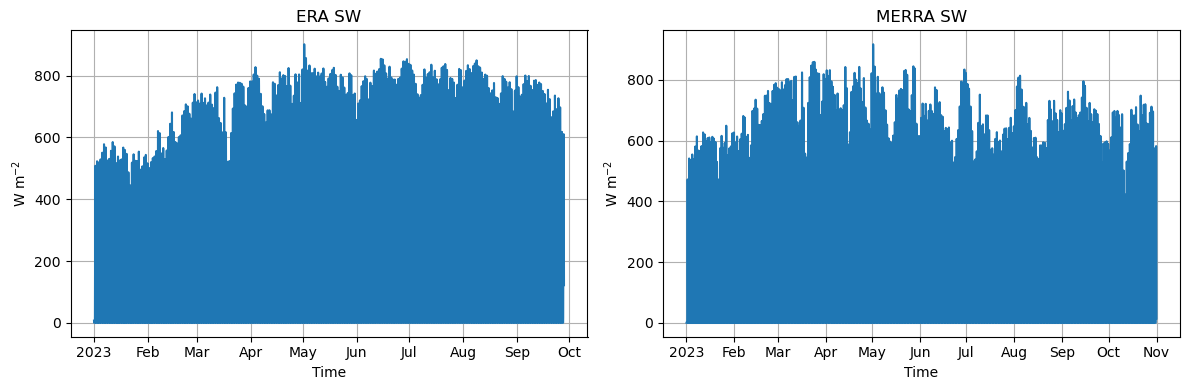

In [6]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))
era_hrly.ssr.mean(['latitude', 'longitude']).plot(ax=ax0)
ax0.set_title('ERA SW')
ax0.set_xlabel('Time')
ax0.set_ylabel(r'W m$^{-2}$')
ax0.grid()
merra_hrly.SWGNT.mean(['lat', 'lon']).plot(ax=ax1)
ax1.set_title('MERRA SW')
ax1.set_xlabel('Time')
ax1.set_ylabel(r'W m$^{-2}$')
ax1.grid()
plt.tight_layout();

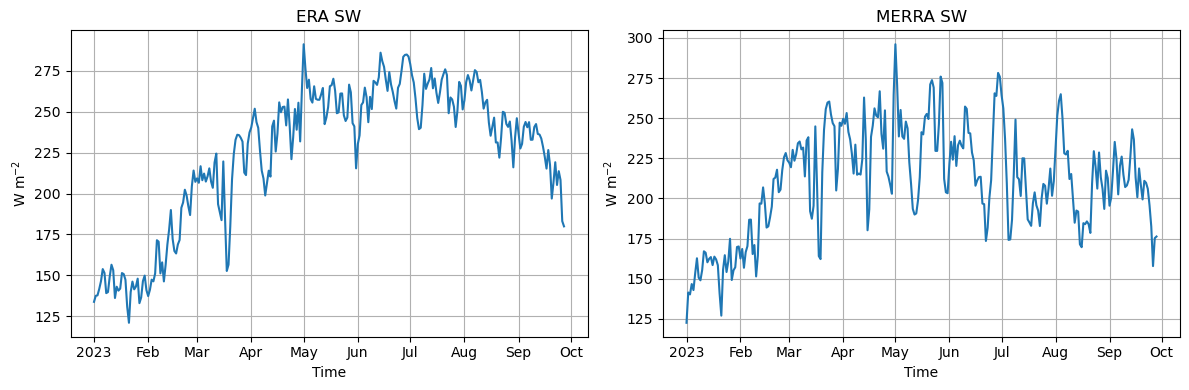

In [7]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))
era.ssr.mean(['latitude', 'longitude']).plot(ax=ax0)
ax0.grid()
ax0.set_title('ERA SW')
ax0.set_xlabel('Time')
ax0.set_ylabel(r'W m$^{-2}$')
merra.SWGNT.mean(['lat', 'lon']).plot(ax=ax1)
ax1.grid()
ax1.set_title('MERRA SW')
ax1.set_xlabel('Time')
ax1.set_ylabel(r'W m$^{-2}$')
plt.tight_layout();

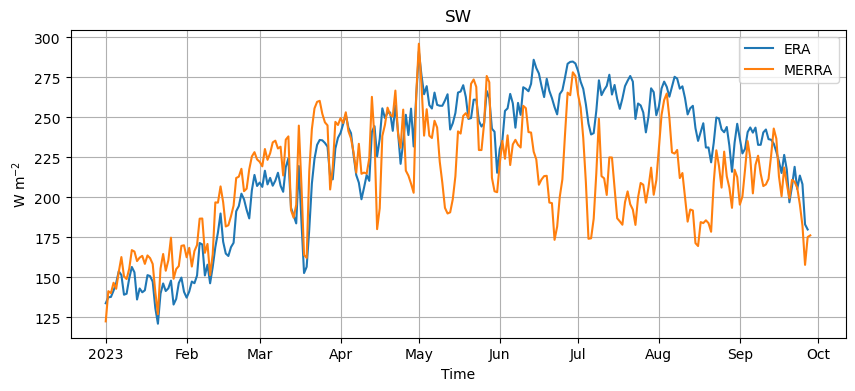

In [8]:
plt.figure(figsize=(10,4))
era.ssr.mean(['latitude', 'longitude']).plot(label='ERA')
merra.SWGNT.mean(['lat', 'lon']).plot(label='MERRA')
plt.grid()
plt.title('SW')
plt.ylabel(r'W m$^{-2}$')
plt.xlabel('Time')
plt.legend()

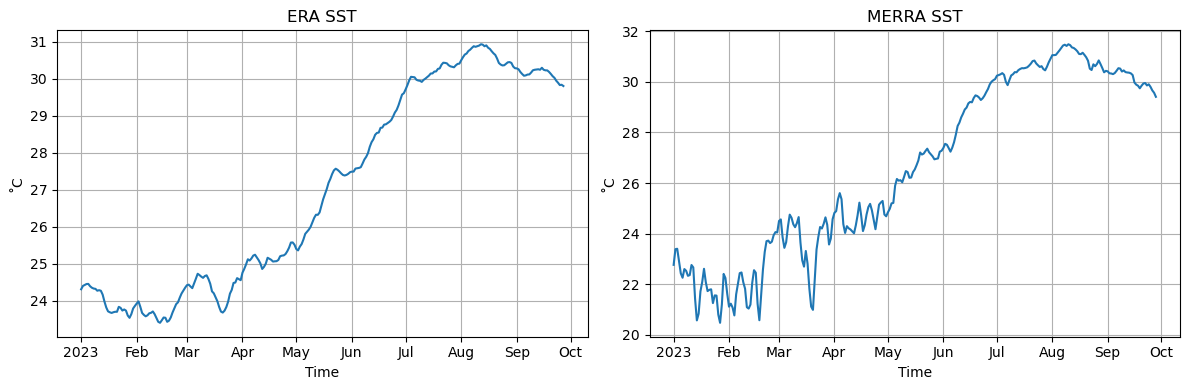

In [9]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))
sst_era.mean(['latitude', 'longitude']).plot(ax=ax0)
ax0.set_title('ERA SST')
ax0.set_xlabel('Time')
ax0.set_ylabel('˚C')
ax0.grid()
sst_merra.mean(['lat', 'lon']).plot(ax=ax1)
ax1.set_title('MERRA SST')
ax1.set_xlabel('Time')
ax1.set_ylabel('˚C')
ax1.grid()
plt.tight_layout();

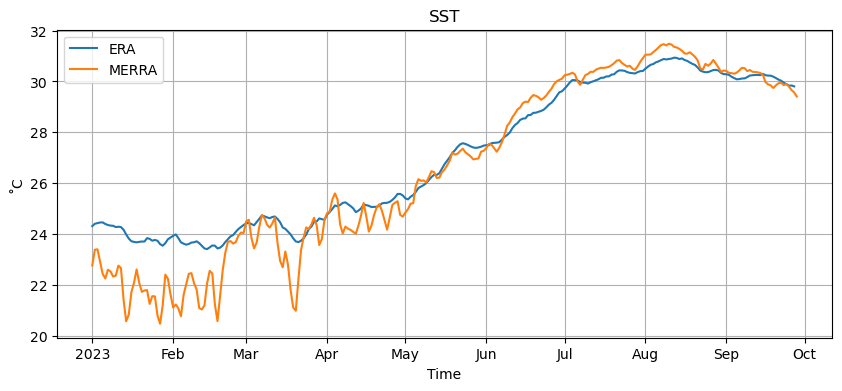

In [10]:
plt.figure(figsize=(10,4))
sst_era.mean(['latitude', 'longitude']).plot(label='ERA')
sst_merra.mean(['lat', 'lon']).plot(label='MERRA')
plt.grid()
plt.title('SST')
plt.ylabel('˚C')
plt.xlabel('Time')
plt.legend()

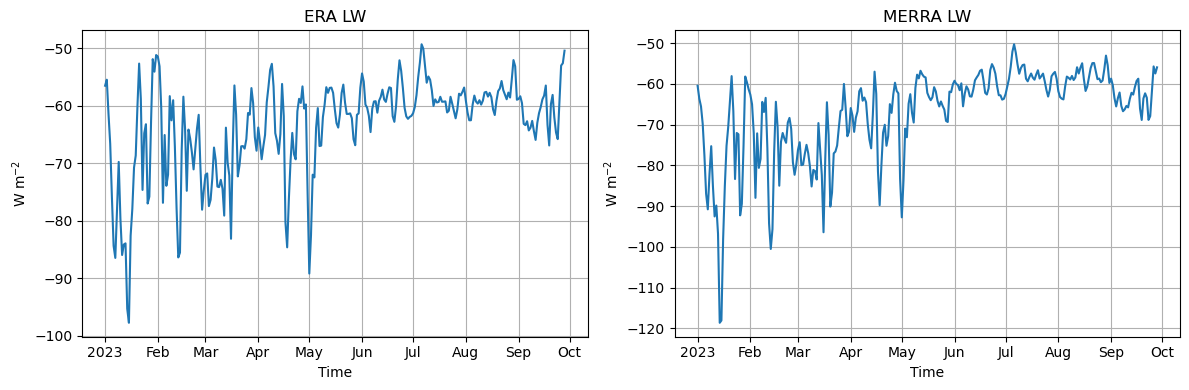

In [11]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))
era.str.mean(['latitude', 'longitude']).plot(ax=ax0)
ax0.grid()
ax0.set_title('ERA LW')
ax0.set_xlabel('Time')
ax0.set_ylabel(r'W m$^{-2}$')
merra.LWGNT.mean(['lat', 'lon']).plot(ax=ax1)
ax1.grid()
ax1.set_title('MERRA LW')
ax1.set_xlabel('Time')
ax1.set_ylabel(r'W m$^{-2}$')
plt.tight_layout();

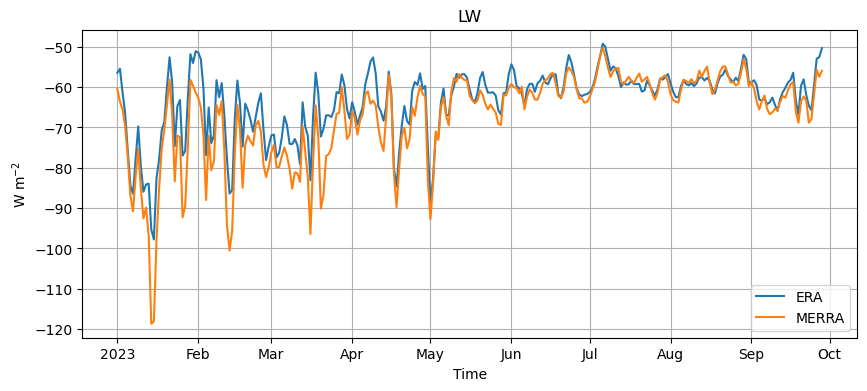

In [12]:
plt.figure(figsize=(10,4))
era.str.mean(['latitude', 'longitude']).plot(label='ERA')
merra.LWGNT.mean(['lat', 'lon']).plot(label='MERRA')
plt.grid()
plt.title('LW')
plt.ylabel(r'W m$^{-2}$')
plt.xlabel('Time')
plt.legend()

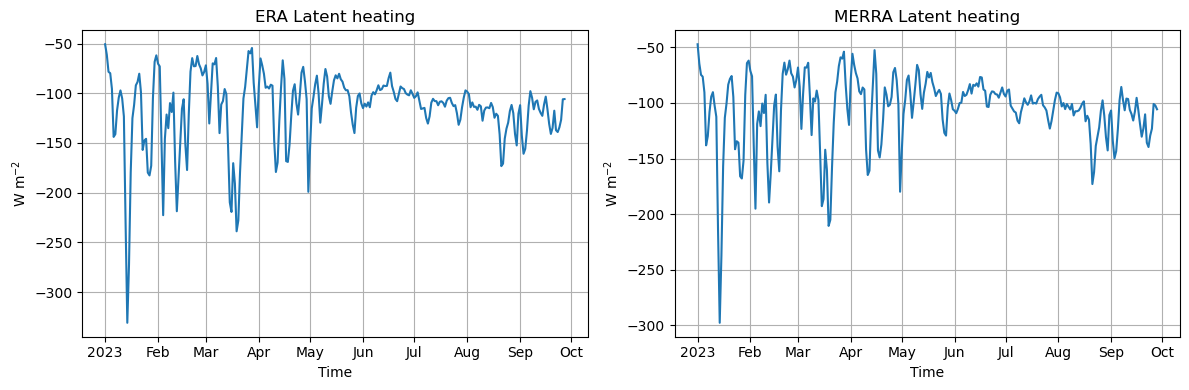

In [13]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))
era.slhf.mean(['latitude', 'longitude']).plot(ax=ax0)
ax0.grid()
ax0.set_title('ERA Latent heating')
ax0.set_xlabel('Time')
ax0.set_ylabel(r'W m$^{-2}$')
(-merra.EFLUX).mean(['lat', 'lon']).plot(ax=ax1)
ax1.grid()
ax1.set_title('MERRA Latent heating')
ax1.set_xlabel('Time')
ax1.set_ylabel(r'W m$^{-2}$')
plt.tight_layout();

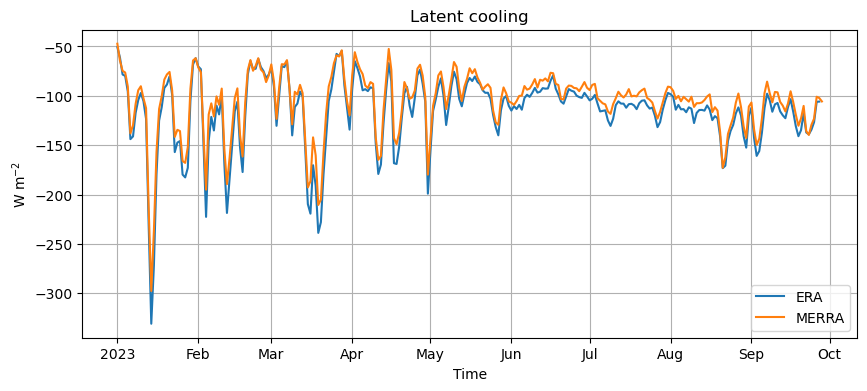

In [14]:
plt.figure(figsize=(10,4))
era.slhf.mean(['latitude', 'longitude']).plot(label='ERA')
(-merra.EFLUX).mean(['lat', 'lon']).plot(label='MERRA')
plt.grid()
plt.title('Latent cooling')
plt.ylabel(r'W m$^{-2}$')
plt.xlabel('Time')
plt.legend()

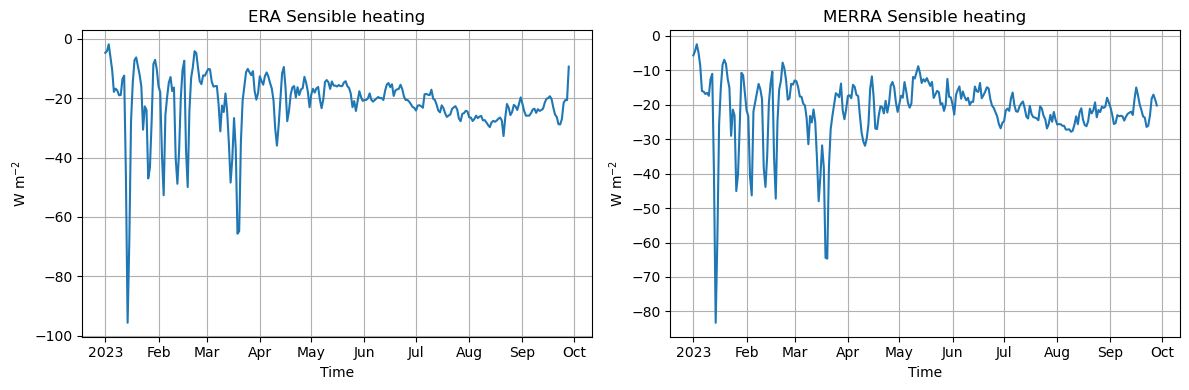

In [15]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))
era.sshf.mean(['latitude', 'longitude']).plot(ax=ax0)
ax0.grid()
ax0.set_title('ERA Sensible heating')
ax0.set_xlabel('Time')
ax0.set_ylabel(r'W m$^{-2}$')
(-merra.HFLUX).mean(['lat', 'lon']).plot(ax=ax1)
ax1.grid()
ax1.set_title('MERRA Sensible heating')
ax1.set_xlabel('Time')
ax1.set_ylabel(r'W m$^{-2}$')
plt.tight_layout();

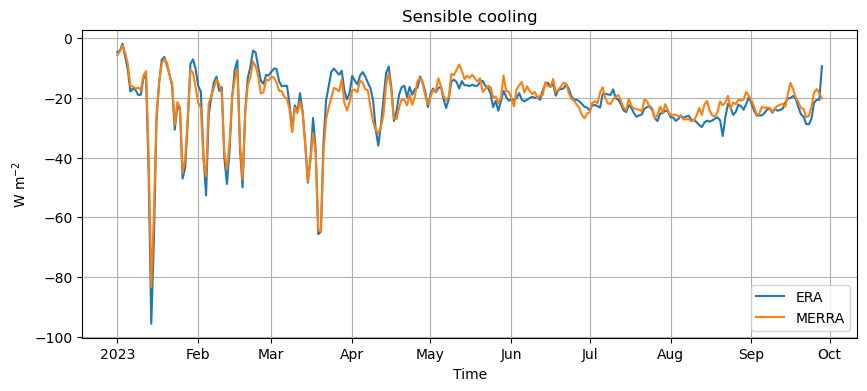

In [16]:
plt.figure(figsize=(10,4))
era.sshf.mean(['latitude', 'longitude']).plot(label='ERA')
(-merra.HFLUX).mean(['lat', 'lon']).plot(label='MERRA')
plt.grid()
plt.title('Sensible cooling')
plt.ylabel(r'W m$^{-2}$')
plt.xlabel('Time')
plt.legend()

## Create grid and area objects

In [17]:
era = xr.merge([era.drop_vars('sst'), sst_era])

In [18]:
merra = xr.merge([merra.drop_vars('TS'), sst_merra])

In [19]:
ds_full_e = generate_grid_ds(era, {'X':'longitude', 'Y':'latitude'})
ds_full_m = generate_grid_ds(merra, {'X':'lon', 'Y':'lat'})

In [20]:
grid_e = xgcm.Grid(ds_full_e, periodic='X')
grid_m = xgcm.Grid(ds_full_m, periodic='X')

In [21]:
ds_full_e

<xarray.Dataset> Size: 63MB
Dimensions:         (latitude: 37, longitude: 113, time: 271,
                     longitude_left: 113, latitude_left: 37)
Coordinates:
  * latitude        (latitude) float32 148B 22.0 22.25 22.5 ... 30.5 30.75 31.0
  * longitude       (longitude) float32 452B -100.0 -99.75 ... -72.25 -72.0
  * time            (time) datetime64[ns] 2kB 2023-01-01 ... 2023-09-28
  * longitude_left  (longitude_left) float32 452B -100.1 -99.88 ... -72.12
  * latitude_left   (latitude_left) float32 148B 21.88 22.12 ... 30.62 30.88
Data variables:
    slhf            (time, latitude, longitude) float64 9MB dask.array<chunksize=(135, 7, 29), meta=np.ndarray>
    sshf            (time, latitude, longitude) float64 9MB dask.array<chunksize=(135, 7, 29), meta=np.ndarray>
    ssr             (time, latitude, longitude) float64 9MB dask.array<chunksize=(135, 7, 29), meta=np.ndarray>
    ssrd            (time, latitude, longitude) float64 9MB dask.array<chunksize=(135, 7, 29), meta=np.ndarray>
    str             (time, latitude, longitude) float64 9MB dask.array<chunksize=(135, 7, 29), meta=np.ndarray>
    strd            (time, latitude, longitude) float64 9MB dask.array<chunksize=(135, 7, 29), meta=np.ndarray>
    sst             (time, latitude, longitude) float64 9MB dask.array<chunksize=(135, 7, 29), meta=np.ndarray>
Attributes:
    long_name:  Sea surface temperature
    units:      K

In [22]:
grid_e

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   longitude --> left
  * left     longitude_left --> center
Y Axis (periodic, boundary=None):
  * center   latitude --> left
  * left     latitude_left --> center

In [23]:
def deg_2_m(grid_obj, ds_obj, lat, lon):
    #calculating meters per latitudinal & longitudinal degree
    earth_radius = 6.371e6
    earth_circumference = 2*np.pi*earth_radius
    meters_per_degree = earth_circumference / 360
    meters_per_degree
    
    #converting lat from degrees to meters
    delta_lat = grid_obj.diff(ds_obj[f'{lat}'], 'Y', boundary='fill', fill_value=np.nan)
    dy = delta_lat * meters_per_degree
    delta_lat_l = grid_obj.diff(ds_obj[f'{lat}_left'], 'Y', boundary='fill', fill_value=np.nan)
    dy_l = delta_lat_l * meters_per_degree

    #converting degrees lon to lon [meters] (pinching at the poles)
    delta_lon = grid_obj.diff(ds_obj[f'{lon}'], 'X')#, boundary_discontinuity=360)
    dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}']))
    delta_lon_l = grid_obj.diff(ds_obj[f'{lon}_left'], 'X')#, boundary_discontinuity=360)
    dx_l = delta_lon_l * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}_left']))
    
    elements = xr.merge([dx.rename('dx'), dx_l.rename('dx_l'), 
                          dy.rename('dy'), dy_l.rename('dy_l')])
    
    return (elements)

In [24]:
cell_elements_e = deg_2_m(grid_e, ds_full_e, 'latitude', 'longitude')
cell_elements_m = deg_2_m(grid_m, ds_full_m, 'lat', 'lon')

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


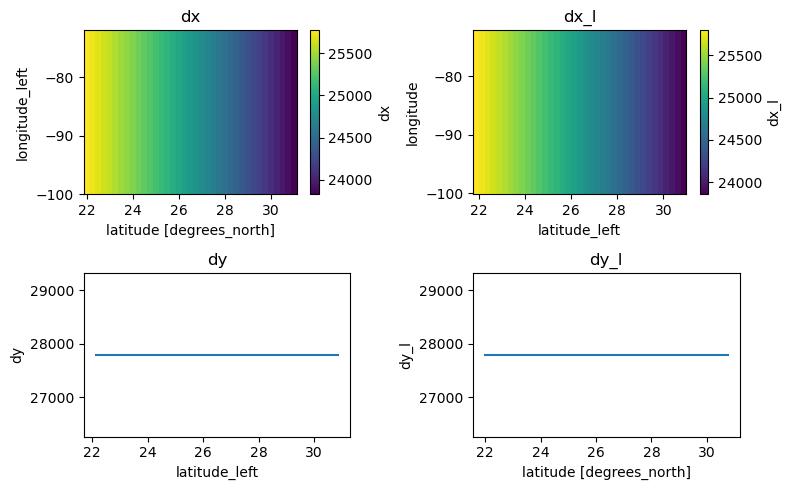

In [25]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements_e.dx[1:].plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements_e.dx_l[:-1].plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements_e.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements_e.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

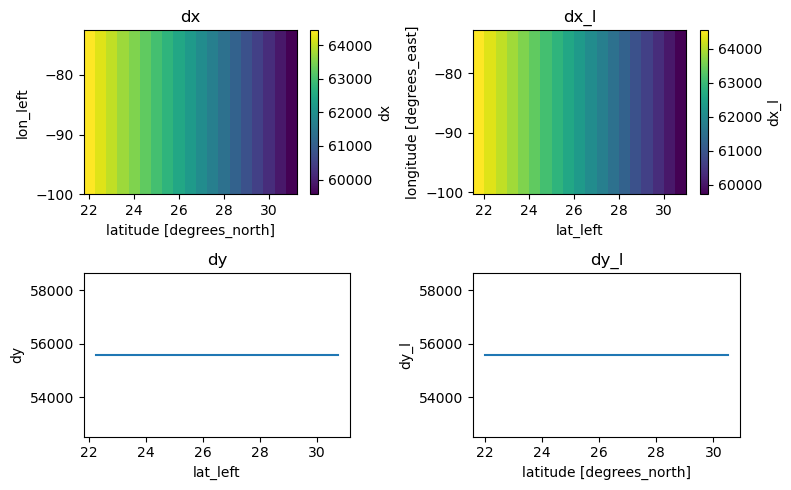

In [26]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements_m.dx[1:].plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements_m.dx_l[:-1].plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements_m.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements_m.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

#### Create mask

In [27]:
mask_e = era.sst[0].isnull()
#mask_m = merra.TS[0].isnull()

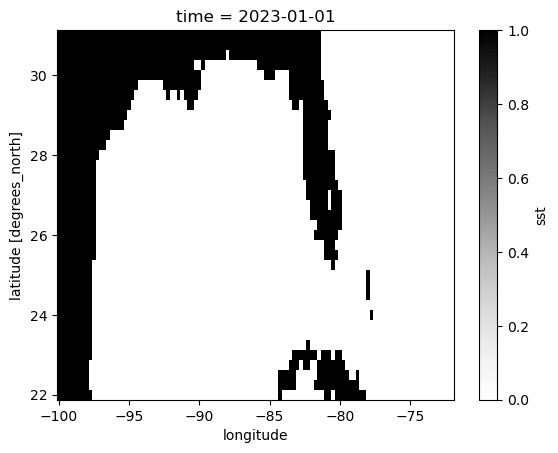

In [28]:
cmap = plt.colormaps.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask_e.plot(cmap=cmap);

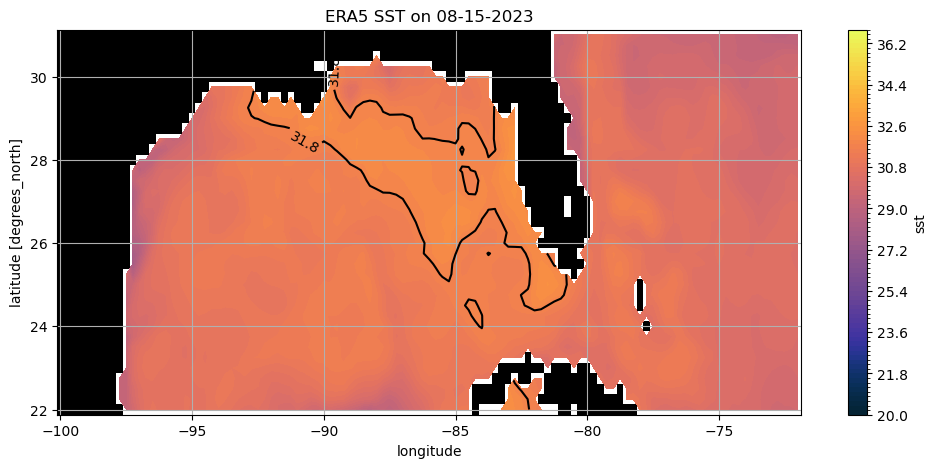

In [29]:
plt.figure(figsize=(12,5))

cmap = plt.colormaps.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask_e.plot(cmap=cmap, add_colorbar=False)

era.sst.sel(time='2023-08-15', method='nearest').plot.contourf(levels=np.arange(20, 37, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
c = era.sst.sel(time='2023-08-15', method='nearest').plot.contour(levels=[31.8], colors='k')
plt.clabel(c)
plt.grid()
plt.title('ERA5 SST on 08-15-2023');

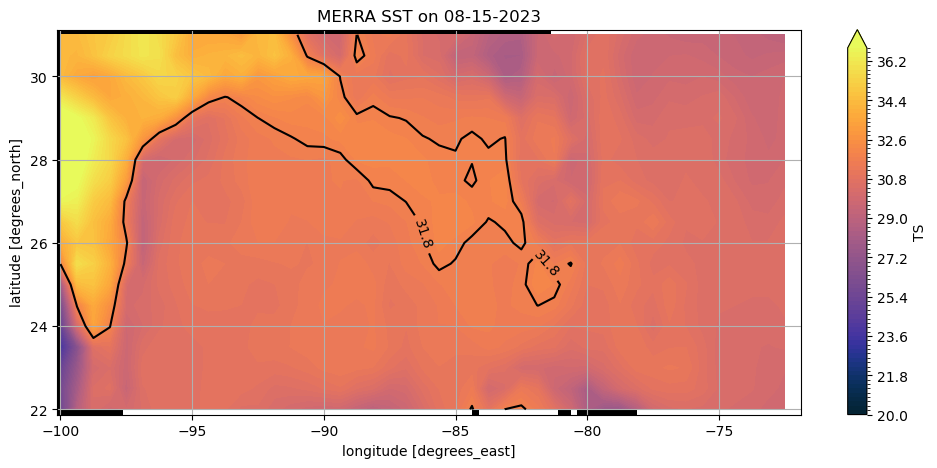

In [30]:
plt.figure(figsize=(12,5))

cmap = plt.colormaps.get_cmap("Greys")
cmap.set_bad('red', 1.)

mask_e.plot(cmap=cmap, add_colorbar=False)
merra.TS.sel(time='2023-08-15', method='nearest').plot.contourf(levels=np.arange(20, 37, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
c = merra.TS.sel(time='2023-08-15', method='nearest').plot.contour(levels=[31.8], colors='k')
plt.clabel(c)
plt.grid()
plt.title('MERRA SST on 08-15-2023');

### Calculate surface area of 31.8˚C contour

In [31]:
wwm_e = era.sst.where(era.sst>=31.8)
wwm_m = merra.TS.where(merra.TS>=31.8)

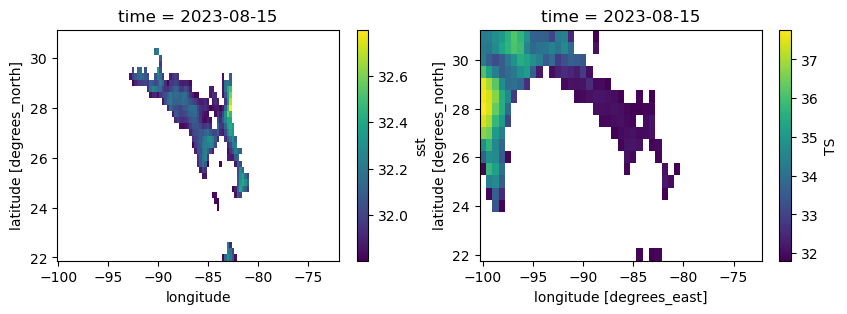

In [32]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
wwm_e.sel(time='2023-08-15').plot(ax=ax0)
wwm_m.sel(time='2023-08-15').plot(ax=ax1)

In [33]:
dx_interp_e = grid_e.interp(cell_elements_e.dx_l, 'Y')
area_e = dx_interp_e * cell_elements_e.dy_l

dx_interp_m = grid_m.interp(cell_elements_m.dx_l, 'Y')
area_m = dx_interp_m * cell_elements_m.dy_l

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


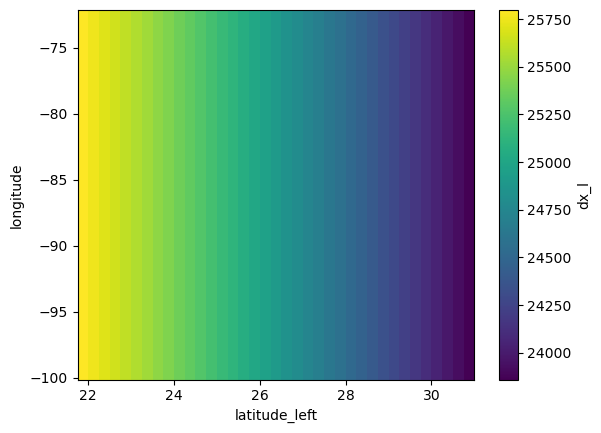

In [34]:
cell_elements_e.dx_l[:-1].plot()

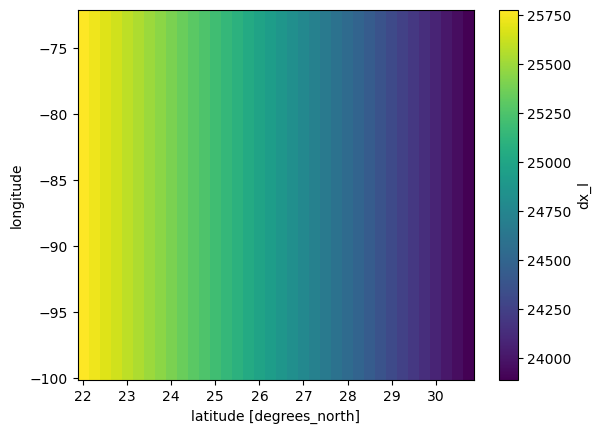

In [35]:
dx_interp_e[:-1,:-1].plot()

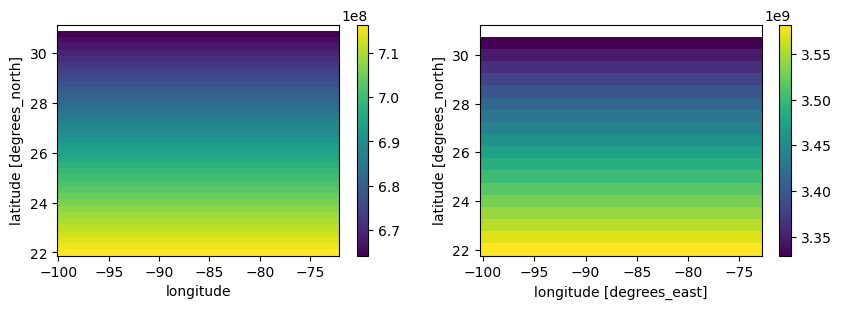

In [36]:
#merra area is 10x larger than era
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
area_e[:-1].T.plot(ax=ax0)
area_m[:-1].T.plot(ax=ax1)

In [37]:
wwme_area_weighted = wwm_e.isel(longitude=slice(None, -1)) * area_e[:-1]
wwmm_area_weighted = wwm_m.isel(lon=slice(None, -1)) * area_m[:-1]

In [38]:
tot_area_e = wwme_area_weighted.sum(['latitude', 'longitude', 'time'])
tot_area_m = wwmm_area_weighted.sum(['lat', 'lon', 'time'])

In [39]:
tot_area_e.compute()

<xarray.DataArray ()> Size: 8B
array(1.58958151e+14)

In [40]:
tot_area_m.compute()

<xarray.DataArray ()> Size: 8B
array(1.16388807e+15)

In [41]:
wwme_area_weighted.sum(['latitude', 'longitude']).argmax().values

array(224)

In [42]:
wwmm_area_weighted.sum(['lat', 'lon']).argmax().values

array(222)

In [43]:
wwme_area_weighted[224].time

<xarray.DataArray 'time' ()> Size: 8B
array('2023-08-13T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2023-08-13

In [44]:
wwmm_area_weighted[222].time

<xarray.DataArray 'time' ()> Size: 8B
array('2023-08-11T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2023-08-11

In [45]:
print('Area of WWM_era max extent:', '{0:.5g}'.format(wwme_area_weighted[224].sum(['latitude', 'longitude']).values))

Area of WWM_era max extent: 1.0466e+13


In [46]:
print('Area of WWM_merra max extent:', '{0:.5g}'.format(wwmm_area_weighted[222].sum(['lat', 'lon']).values))

Area of WWM_merra max extent: 2.2695e+13


# Budget

In [39]:
np.diff(era.time)/1e9

array([86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400,

In [40]:
np.diff(merra.time)/1e9

array([86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400, 86400,
       86400, 86400,

In [91]:
Cp = heat_capacity_cp = 3.994e3 #J/kg/˚C
rho = 1030 #kg/m^3

#(W/m^2) x 1/Cp x 1/rho x area
era_weighted = (era.isel(longitude=slice(None, -1), latitude=slice(None, -1)) * 
                area_e.isel(longitude=slice(None, -1), latitude=slice(None, -1)) * (1/Cp) * (1/rho)) #˚C m^3/s
merra_weighted = (merra.isel(lon=slice(None, -1), lat=slice(None, -1)) * 
                  area_m.isel(lon=slice(None, -1), lat=slice(None, -1)) * (1/Cp) * (1/rho)) #˚C m^3/s

In [92]:
delta_theta = 0.1
theta_bins = np.arange(20, 38, delta_theta)

def hist_func(ds, sst, lat, lon, variable):
    hist = histogram(sst.rename('theta'), bins=[theta_bins],
                    weights=ds[variable].fillna(0.),
                    dim=[lon, lat]) / delta_theta
    return hist #m^3/s (Sv)

In [93]:
era_hist_uncut = xr.merge([hist_func(era_weighted, era.sst.isel(longitude=slice(None, -1), latitude=slice(None, -1)), 
                                     'latitude', 'longitude', var).rename('omega_'+var) 
                     for var in list(era_weighted)[:-1]])
merra_hist = xr.merge([hist_func(merra_weighted, merra.TS.isel(lon=slice(None, -1), lat=slice(None, -1)), 
                                 'lat', 'lon', var).rename('omega_'+var)
                      for var in list(merra_weighted)[:-1]])

In [94]:
era_hist = era_hist_uncut.drop_vars(['omega_ssrd', 'omega_strd'])
merra_hist['omega_HFLUX'] = -merra_hist['omega_HFLUX']
merra_hist['omega_EFLUX'] = -merra_hist['omega_EFLUX']

In [95]:
era_hist.load()
merra_hist.load()

<xarray.Dataset> Size: 2MB
Dimensions:      (time: 271, theta_bin: 179)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2023-01-01 2023-01-02 ... 2023-09-28
  * theta_bin    (theta_bin) float64 1kB 20.05 20.15 20.25 ... 37.65 37.75 37.85
Data variables:
    omega_EFLUX  (time, theta_bin) float64 388kB -9.571e+05 -1.338e+06 ... -0.0
    omega_HFLUX  (time, theta_bin) float64 388kB -3.449e+05 -1.039e+06 ... -0.0
    omega_LWGNT  (time, theta_bin) float64 388kB -3.233e+06 -2.475e+06 ... 0.0
    omega_SWGNT  (time, theta_bin) float64 388kB 7.313e+06 5.123e+06 ... 0.0 0.0

- sw = ssr 
- lw = str 
- sensible = sshf 
- latent = slhf 
- evap = e 
- runoff = ro 

<Figure size 2500x500 with 0 Axes>

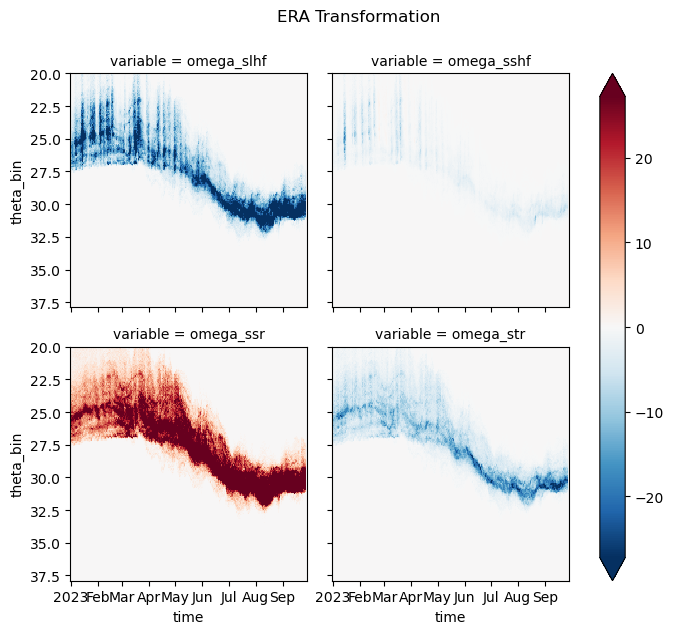

In [96]:
plt.figure(figsize=(25,5))
(era_hist/1e6).to_array().plot(col='variable', col_wrap=2, x='time', 
                               yincrease=False, robust=True)
plt.suptitle('ERA Transformation', y=1.05);

<Figure size 2500x500 with 0 Axes>

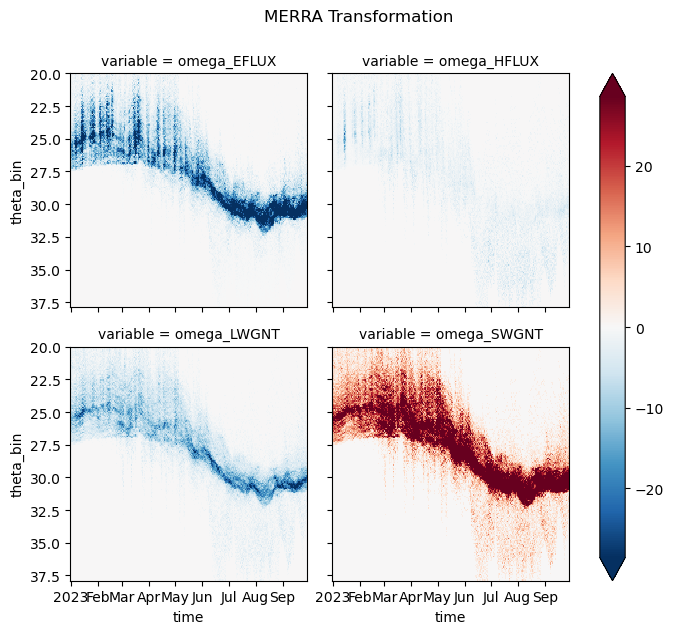

In [97]:
plt.figure(figsize=(25,5))
(merra_hist/1e6).to_array().plot(col='variable', col_wrap=2, x='time', 
                               yincrease=False, robust=True)
plt.suptitle('MERRA Transformation', y=1.05);

In [98]:
one_plt_era = era_hist.sel(theta_bin=31.8, method='nearest')
one_plt_merra = merra_hist.sel(theta_bin=31.8, method='nearest')

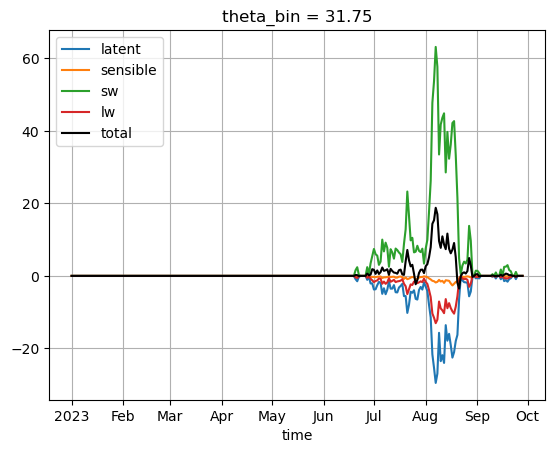

In [99]:
(one_plt_era.omega_slhf/1e6).plot(label='latent')
(one_plt_era.omega_sshf/1e6).plot(label='sensible')
(one_plt_era.omega_ssr/1e6).plot(label='sw')
(one_plt_era.omega_str/1e6).plot(label='lw')
(one_plt_era/1e6).to_array().sum('variable').plot(label='total', color='k')
plt.legend()
plt.grid();

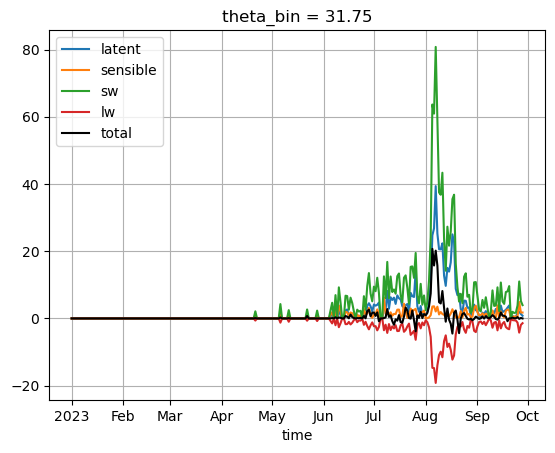

In [100]:
(-one_plt_merra.omega_EFLUX/1e6).plot(label='latent')
(-one_plt_merra.omega_HFLUX/1e6).plot(label='sensible')
(one_plt_merra.omega_SWGNT/1e6).plot(label='sw')
(one_plt_merra.omega_LWGNT/1e6).plot(label='lw')
(one_plt_merra/1e6).to_array().sum('variable').plot(label='total', color='k')
plt.legend()
plt.grid();

In [101]:
one_plt_era_binrange = era_hist.sel(theta_bin=slice(31.8, None)).sum('theta_bin')
one_plt_merra_binrange = merra_hist.sel(theta_bin=slice(31.8, None)).sum('theta_bin')

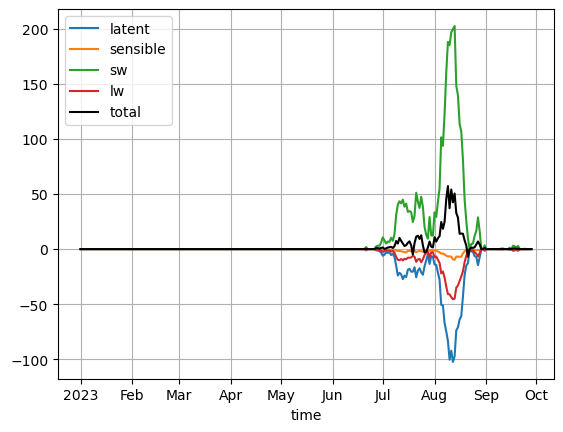

In [102]:
(one_plt_era_binrange.omega_slhf/1e6).plot(label='latent')
(one_plt_era_binrange.omega_sshf/1e6).plot(label='sensible')
(one_plt_era_binrange.omega_ssr/1e6).plot(label='sw')
(one_plt_era_binrange.omega_str/1e6).plot(label='lw')
(one_plt_era_binrange/1e6).to_array().sum('variable').plot(label='total', color='k')
plt.legend()
plt.grid();

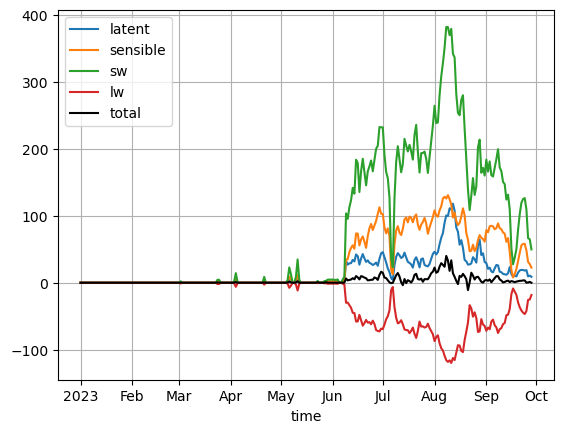

In [104]:
(-one_plt_merra_binrange.omega_EFLUX/1e6).plot(label='latent')
(-one_plt_merra_binrange.omega_HFLUX/1e6).plot(label='sensible')
(one_plt_merra_binrange.omega_SWGNT/1e6).plot(label='sw')
(one_plt_merra_binrange.omega_LWGNT/1e6).plot(label='lw')
(one_plt_merra_binrange/1e6).to_array().sum('variable').plot(label='total', color='k')
plt.legend()
plt.grid();

### Save histograms